## 基于pytorch-lighting的GAN模型
首先是准备数据的模型，这里使用data-loader来加载数据，然后使用pytorch-lighting来构建模型，这里使用的是GAN模型，然后使用pytorch-lighting的trainer来训练模型，最后使用模型来生成图片。

In [205]:
# 导入必要的库
import os
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import torchvision

# 第一部分：数据模块
class MNISTDataModule(pl.LightningDataModule):
    def __init__(self, data_dir='home/huilin/project/data', batch_size=64):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))  # 归一化处理
        ])

    def prepare_data(self):
        # 下载 MNIST 数据
        MNIST(self.data_dir, train=True, download=True, transform=self.transform)
        MNIST(self.data_dir, train=False, download=True, transform=self.transform)

    def setup(self, stage=None):
        # 设置数据集，用于训练和验证
        mnist_full = MNIST(self.data_dir, train=True, transform=self.transform)
        self.mnist_train, self.mnist_val = random_split(mnist_full, [55000, 5000])

    def train_dataloader(self):
        # 返回训练集的 DataLoader
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        # 返回验证集的 DataLoader
        return DataLoader(self.mnist_val, batch_size=self.batch_size)



然后是模型的定义，我们定义了generator和discriminator两个模型，然后定义了GAN模型，然后定义了训练的过程。

In [206]:
# 第二部分：模型定义
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        img_flat = img.view(img.size(0), -1)
        return self.model(img_flat)

class GAN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.automatic_optimization = False  # 手动优化
        self.generator = Generator()
        self.discriminator = Discriminator()

    def forward(self, z):
        return self.generator(z)

    def adversarial_loss(self, y_hat, y):
        return F.binary_cross_entropy(y_hat, y)

    def training_step(self, batch, batch_idx):
        imgs, _ = batch

        # 生成随机噪声
        z = torch.randn(imgs.shape[0], 100, device=self.device)
        # 生成器生成假图片
        generated_imgs = self(z)

        # 判别器判别真实图片和生成图片
        real = torch.ones(imgs.size(0), 1, device=self.device)
        fake = torch.zeros(imgs.size(0), 1, device=self.device)

        # 训练生成器
        self.generator.zero_grad()
        gen_loss = self.adversarial_loss(self.discriminator(generated_imgs), real)
        self.manual_backward(gen_loss)
        self.optimizers()[0].step()

        # 训练判别器
        self.discriminator.zero_grad()
        real_loss = self.adversarial_loss(self.discriminator(imgs), real)
        fake_loss = self.adversarial_loss(self.discriminator(generated_imgs.detach()), fake)
        dis_loss = (real_loss + fake_loss) / 2
        self.manual_backward(dis_loss)
        self.optimizers()[1].step()

        self.log('gen_loss', gen_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('dis_loss', dis_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)

    def configure_optimizers(self):
        opt_gen = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_dis = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        return [opt_gen, opt_dis]


我们需要设置训练器和数据模块，这部分代码将位于

In [207]:
def train_gan():
    data_module = MNISTDataModule(data_dir='home/huilin/project/data')
    model = GAN()

    trainer = pl.Trainer(
        max_epochs=50,
        enable_progress_bar=True,  # 使用 True 来显示进度条
        #gpus=1,  # 如果有可用的 GPU
        logger=TensorBoardLogger('tb_logs', name='GAN')
    )


    trainer.fit(model, datamodule=data_module)
    trainer.save_checkpoint("/home/huilin/project/gan-model/gan_model.ckpt")





CHECKPOINT_PATH = "/home/huilin/project/gan-model"
pretrained_filename = os.path.join(CHECKPOINT_PATH, f"gan_model.ckpt")
if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = GAN.load_from_checkpoint(pretrained_filename)
else:
        print("No pretrained model found, training...")
        # 执行训练
        train_gan()

Found pretrained model, loading...


模型1的评估

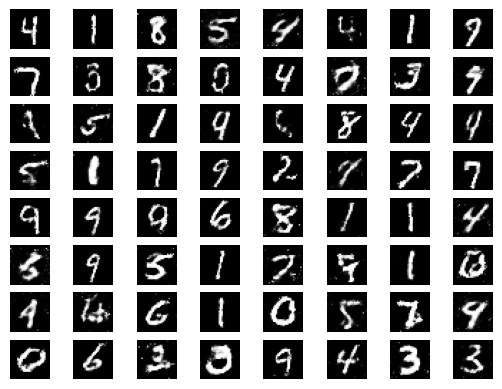

In [208]:
# 第四部分：生成图像
import matplotlib.pyplot as plt
def generate_images(model_path, num_images=64):
    model = GAN.load_from_checkpoint(model_path)
    model.eval()
    model = model.to('cuda')

    z = torch.randn(num_images, 100, device=model.device)
    images = model(z)
    images = (images + 1) / 2  # 将图像数据重新缩放到 [0, 1]
    imgs = []
    for i, image in enumerate(images):
        plt.subplot(8, 8, i+1)
        plt.imshow(image[0].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
        imgs.append(image[0].cpu().detach().numpy())
    #全部图像添加到imgs里面
    return imgs


# 生成图像
imgs = generate_images('/home/huilin/project/gan-model/gan_model.ckpt')

# 模型1 结果
我们看到模型1的结果是生成了一些图片，但是图片的质量不是很高，比如我们又像是0又像是8，1和7...
我们接下来采用VAE来生成
## 评价
这里评价使用part3的deep-energy来实现，我们使用deep-energy来评价生成的图片，然后计算出分数，然后使用分数来评价模型的好坏。

In [209]:
import energy_based_compare
#convert imgs to tensor
#修改imgs成为这种格式imgs = [np.random.randn(28, 28) for _ in range(10)]  # Replace with your actual images
imgs = [torch.tensor(img).unsqueeze(0) for img in imgs]
#计算分数
avg_score = energy_based_compare.compare(imgs)
print(f"Energy-based score: {avg_score}")

Energy-based score: -17.147994995117188


一般情况下我们可以看到score在-17左右，这个和我们的理想情况不太一样，我们肯能需要再对应一下label的话结果会更好？懒得搞下去了